# ODE Demo

#### https://github.com/rtqichen/torchdiffeq/blob/master/examples/ode_demo.py

## Setup

In [1]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [62]:
# NOTE: arguments will be ignored when running this from a jupyter notebook
#       set options manually by changing the defaults here or override below

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=20)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
args, unknown = parser.parse_known_args()


# override any options here
args.viz = True
args.niters = 200
args.test_freq = 5
args.method = "euler"
# args.method = "rk4"
# args.method = "midpoint"


# display current set of args
print(args)

Namespace(method='euler', data_size=1000, batch_time=10, batch_size=20, niters=200, test_freq=5, viz=True, gpu=0, adjoint=False)


In [63]:
# finish setting up here

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

# select device
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

## Data

In [64]:
# define some data

true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., args.data_size).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)


class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)


with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')


## Helper functions

In [65]:
# more helper functions

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:args.batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


In [75]:
# visualization functions

if args.viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    # fig = plt.figure(figsize=(12, 4), facecolor='white')
    # ax_traj = fig.add_subplot(131, frameon=False)
    # ax_phase = fig.add_subplot(132, frameon=False)
    # ax_vecfield = fig.add_subplot(133, frameon=False)
    # plt.show(block=False)


def visualize(true_y, pred_y, odefunc, itr):

    if args.viz:
        
        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(131, frameon=not False)
        ax_phase = fig.add_subplot(132, frameon=not False)
        ax_vecfield = fig.add_subplot(133, frameon=not False)
        # plt.show(block=True)

        # ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj.set_ylim(-2, 2)
        # ax_traj.legend()

        # ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        # ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)

        fig.tight_layout()
        plt.savefig('png/{:03d}'.format(itr))
        plt.draw()
        # plt.pause(0.001)
        plt.show()


## model and training code

In [87]:

class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)
    
    
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0
        self.history = dict(val=[], avg=[])

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        # save histories
        self.history['val'].append(self.val)
        self.history['avg'].append(self.avg)
        

## Training Loop

Iter 0005 | Total Loss 0.788893


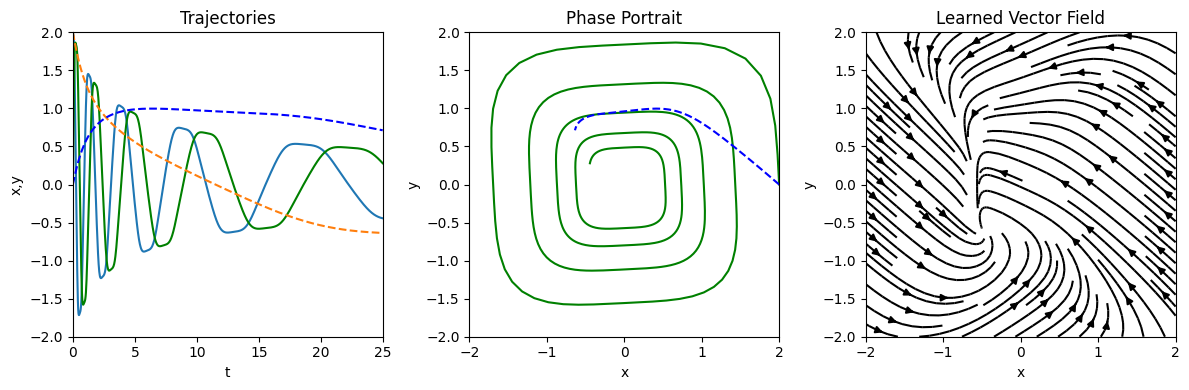

Iter 0010 | Total Loss 0.746342


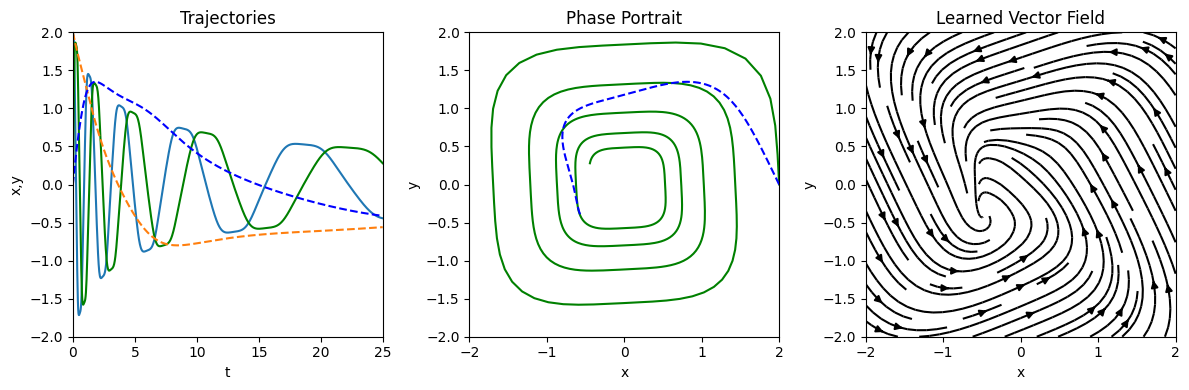

Iter 0015 | Total Loss 0.704129


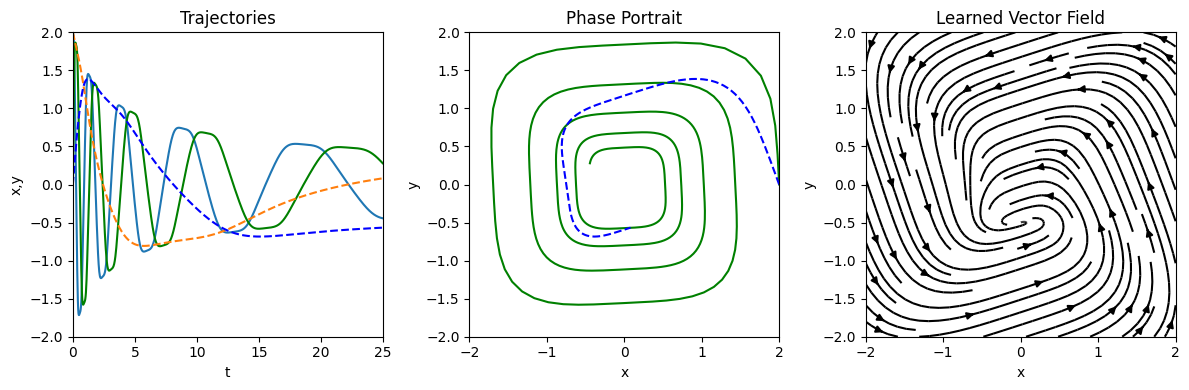

Iter 0020 | Total Loss 0.619489


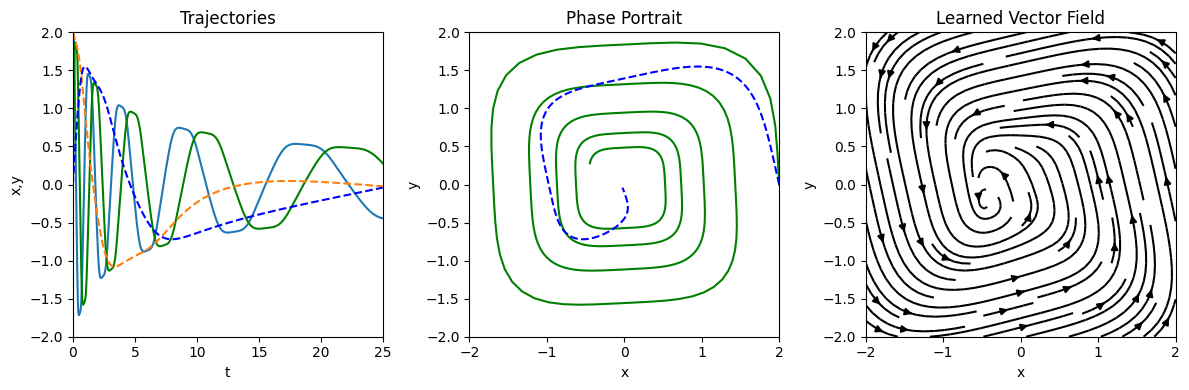

Iter 0025 | Total Loss 0.615659


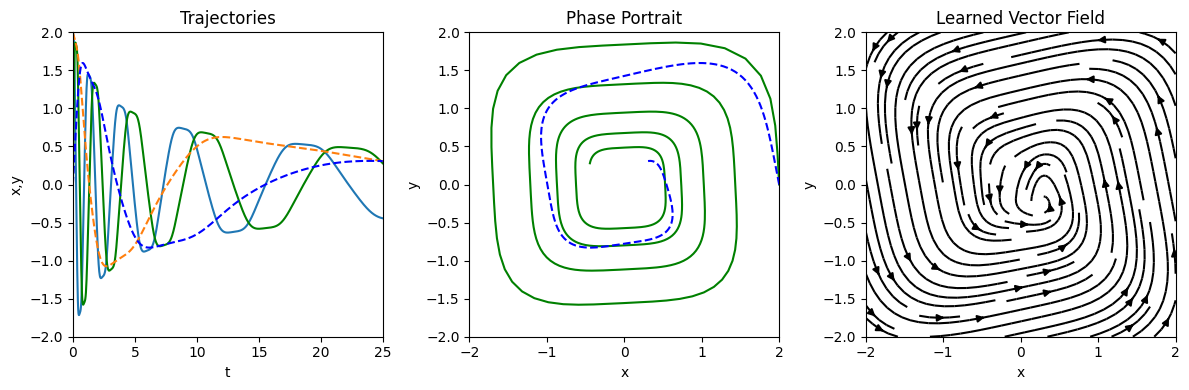

Iter 0030 | Total Loss 0.631083


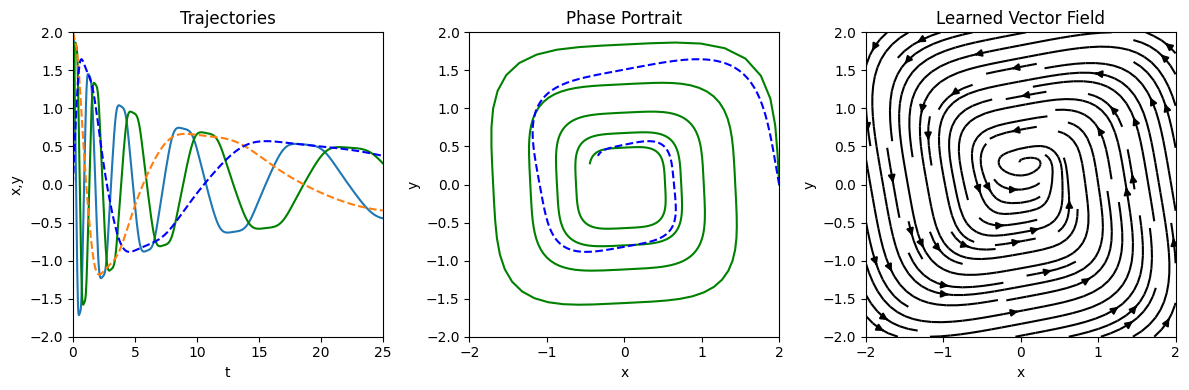

Iter 0035 | Total Loss 0.692968


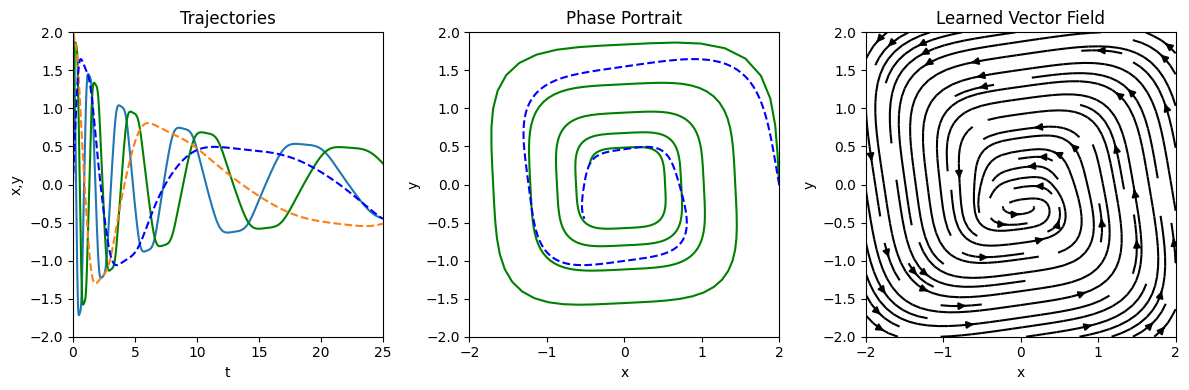

Iter 0040 | Total Loss 0.642483


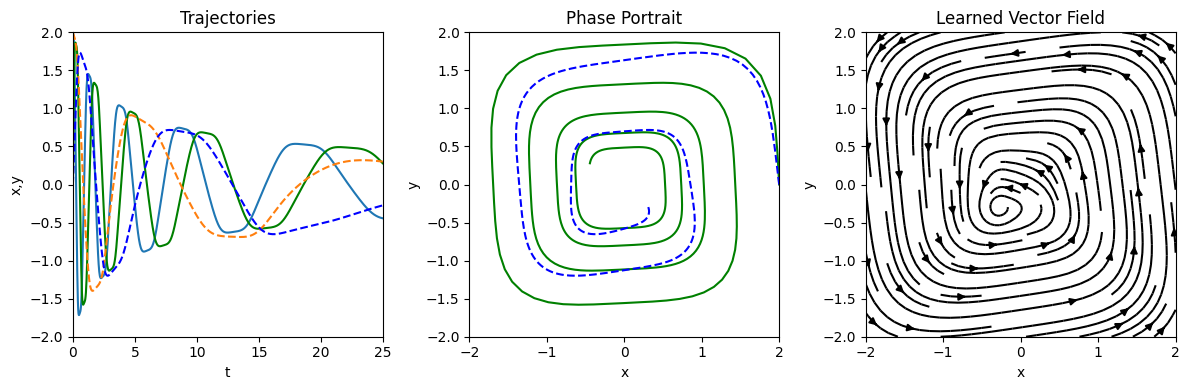

Iter 0045 | Total Loss 0.619502


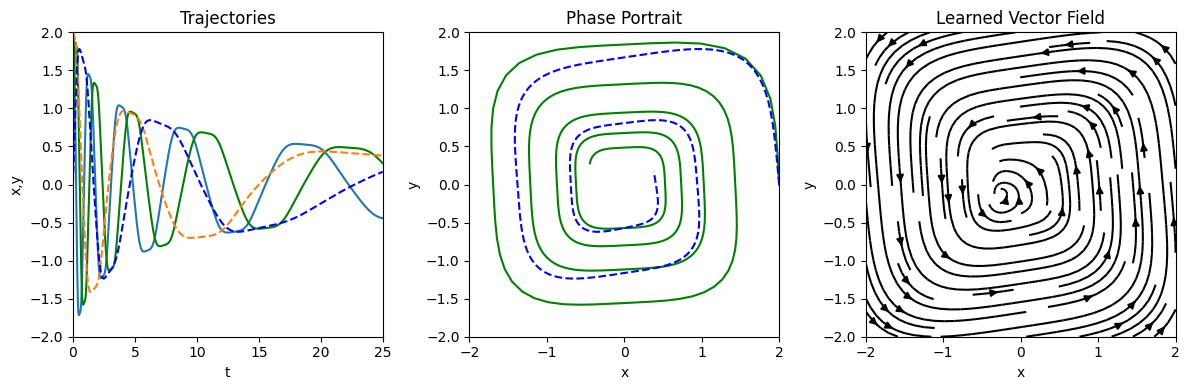

Iter 0050 | Total Loss 0.756412


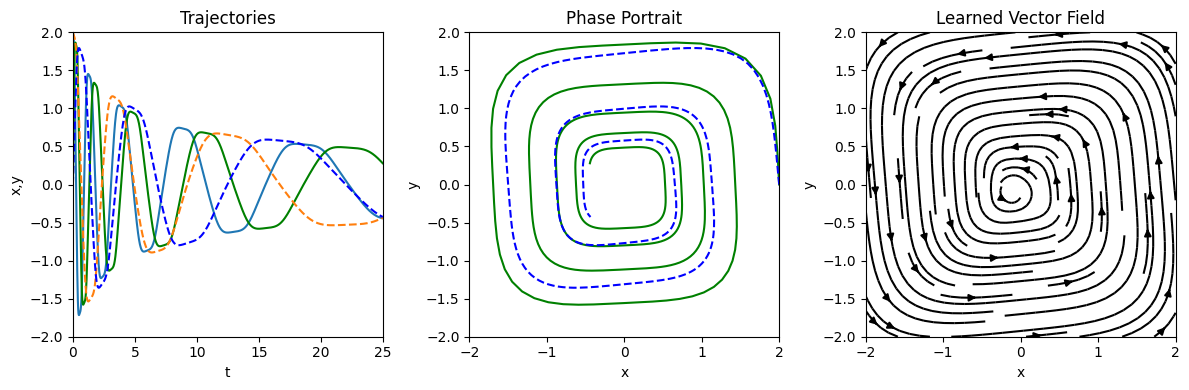

Iter 0055 | Total Loss 0.737921


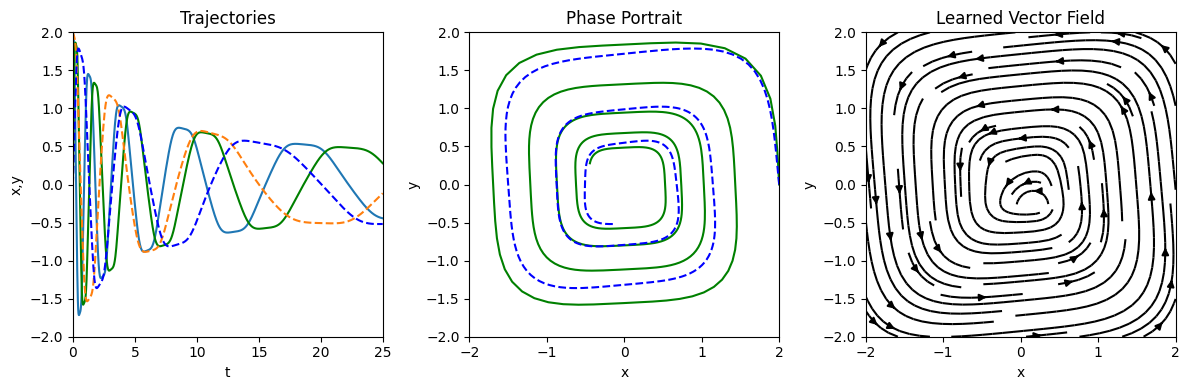

Iter 0060 | Total Loss 0.600208


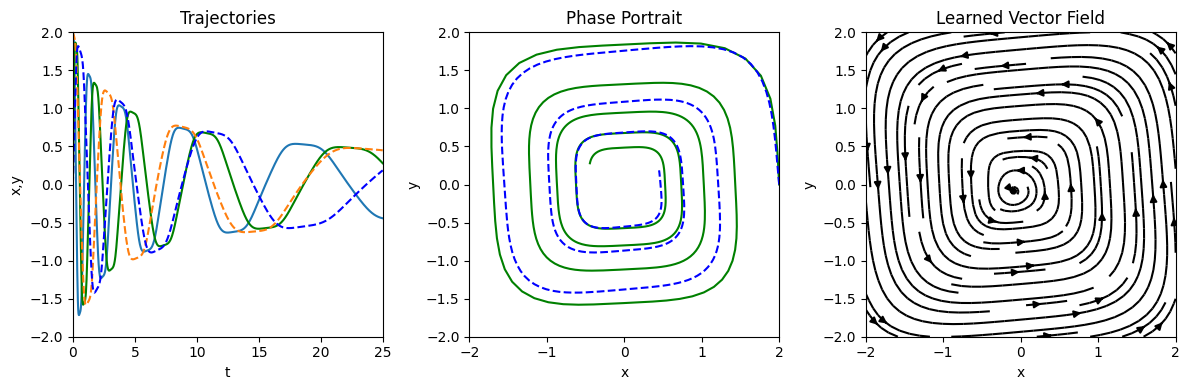

Iter 0065 | Total Loss 0.909507


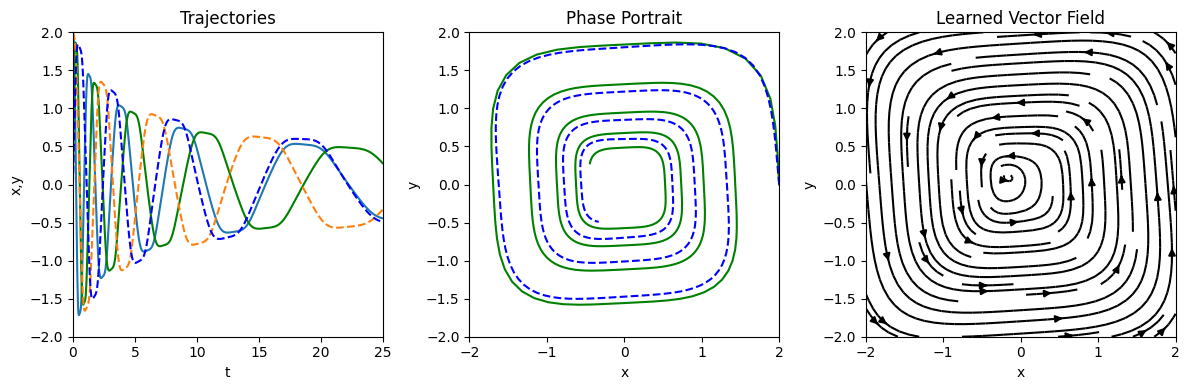

Iter 0070 | Total Loss 0.592709


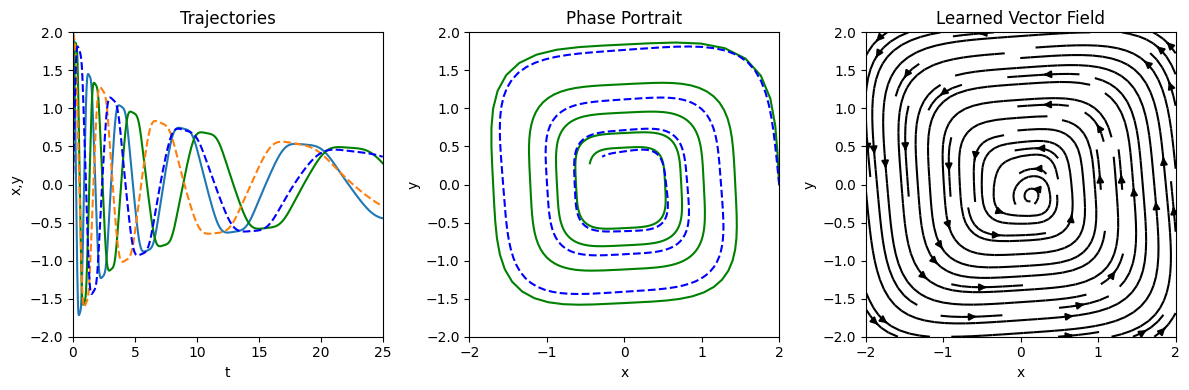

Iter 0075 | Total Loss 1.007540


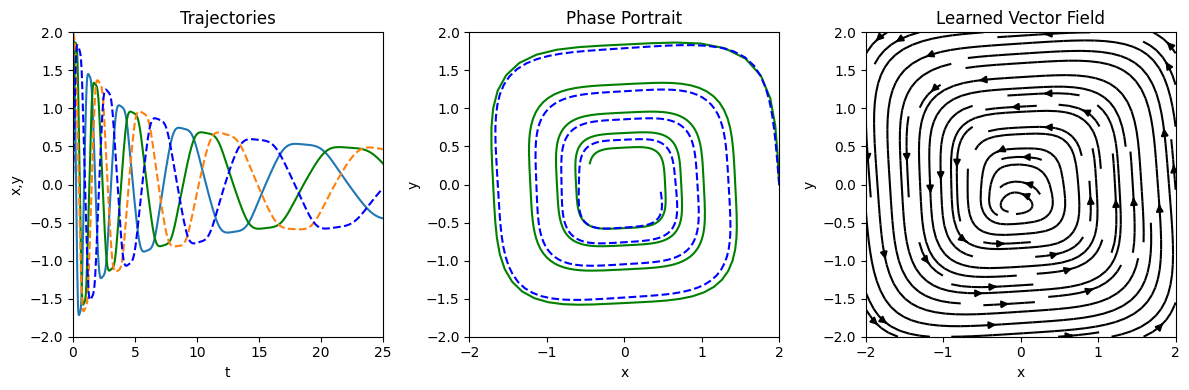

Iter 0080 | Total Loss 0.731036


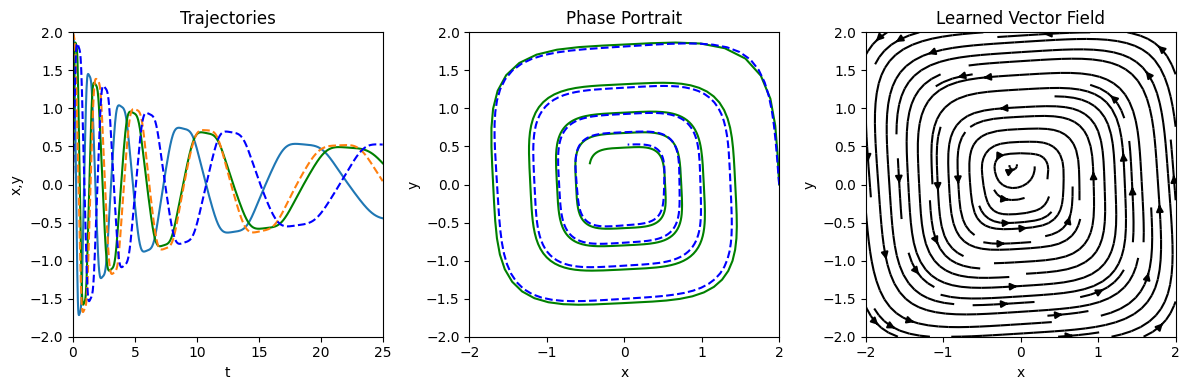

Iter 0085 | Total Loss 0.545017


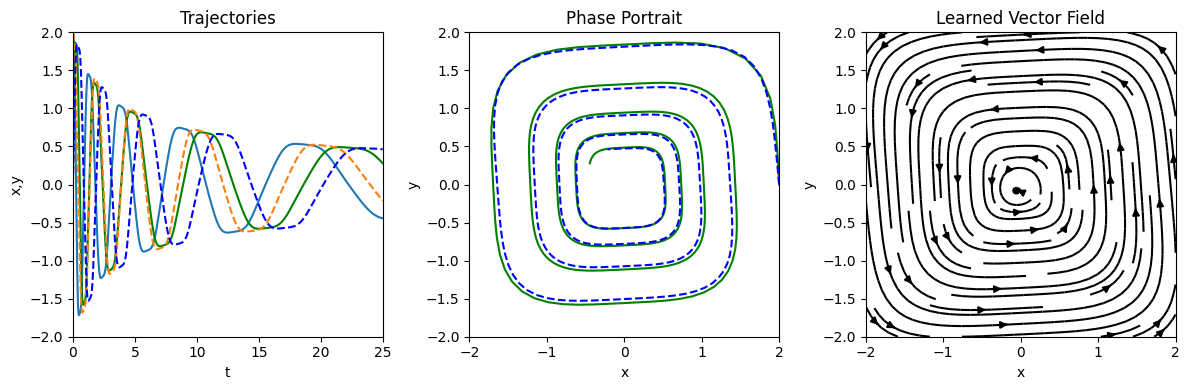

Iter 0090 | Total Loss 0.386982


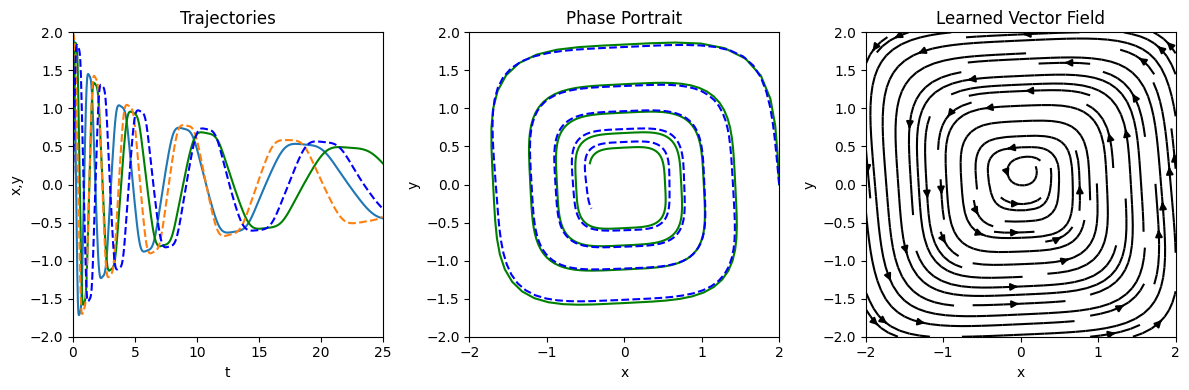

Iter 0095 | Total Loss 0.471497


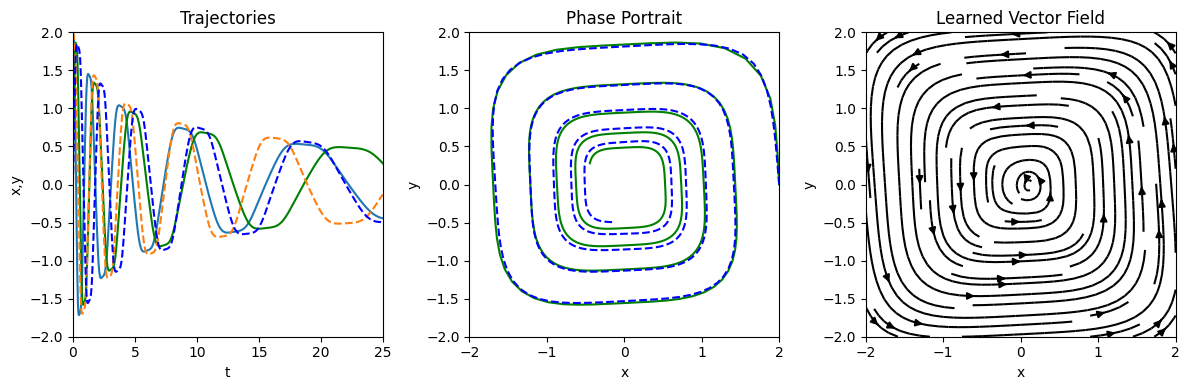

Iter 0100 | Total Loss 0.612726


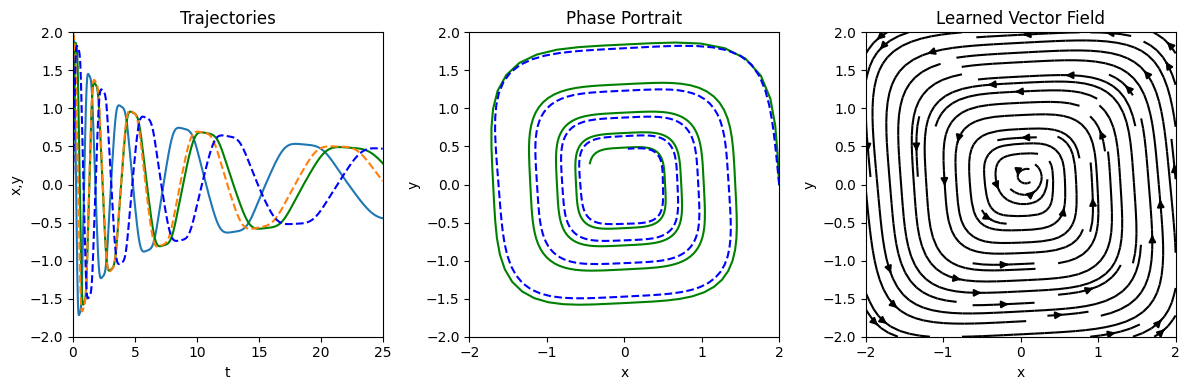

Iter 0105 | Total Loss 0.622972


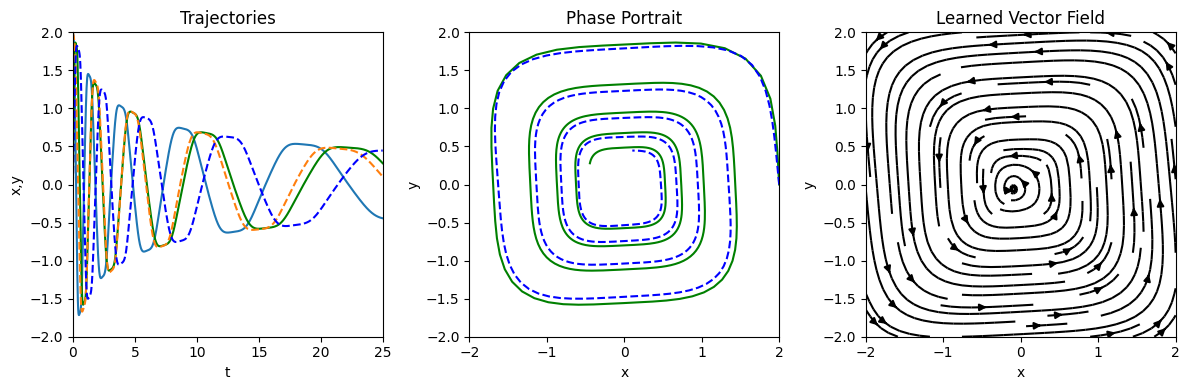

Iter 0110 | Total Loss 0.379372


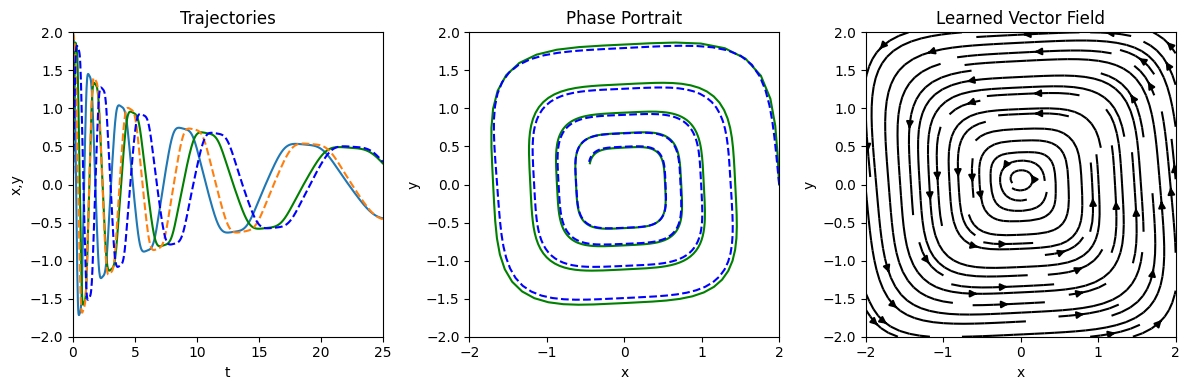

Iter 0115 | Total Loss 0.516493


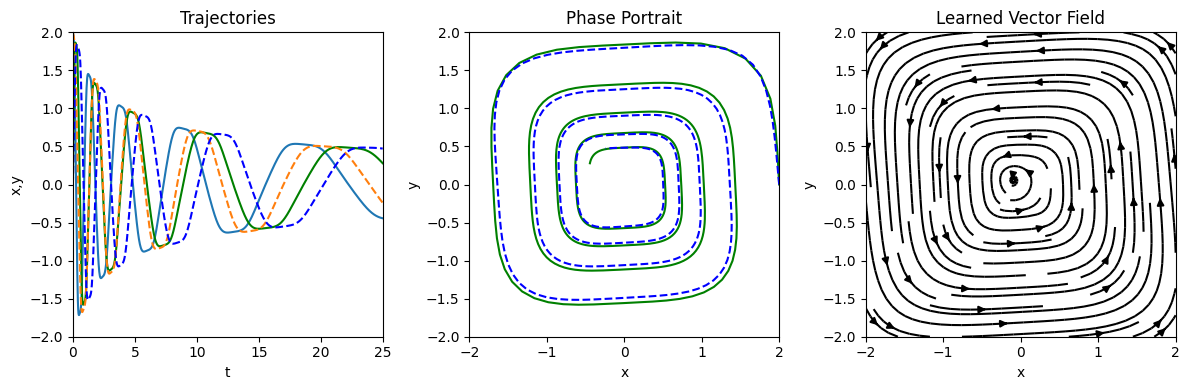

Iter 0120 | Total Loss 0.340152


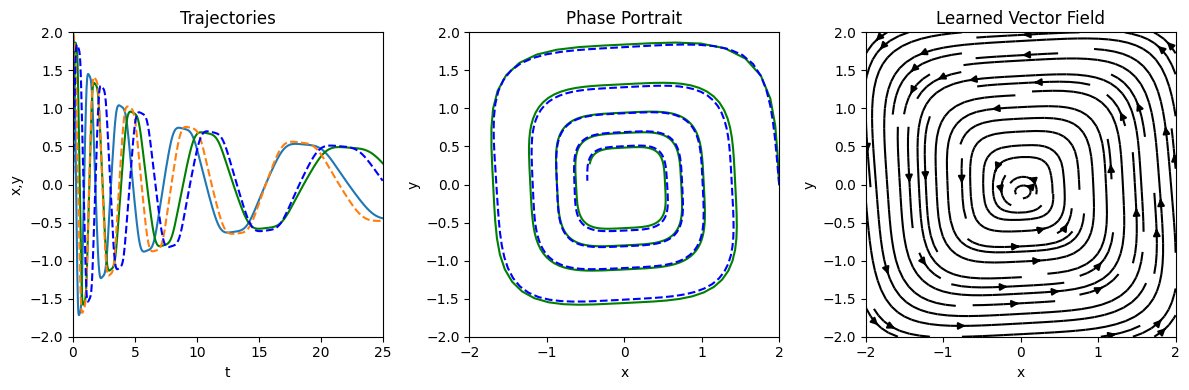

Iter 0125 | Total Loss 0.832116


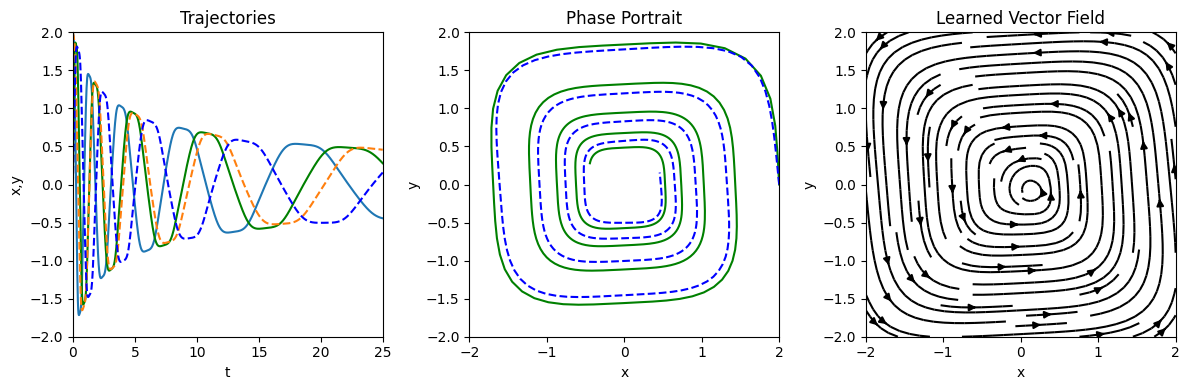

Iter 0130 | Total Loss 0.422693


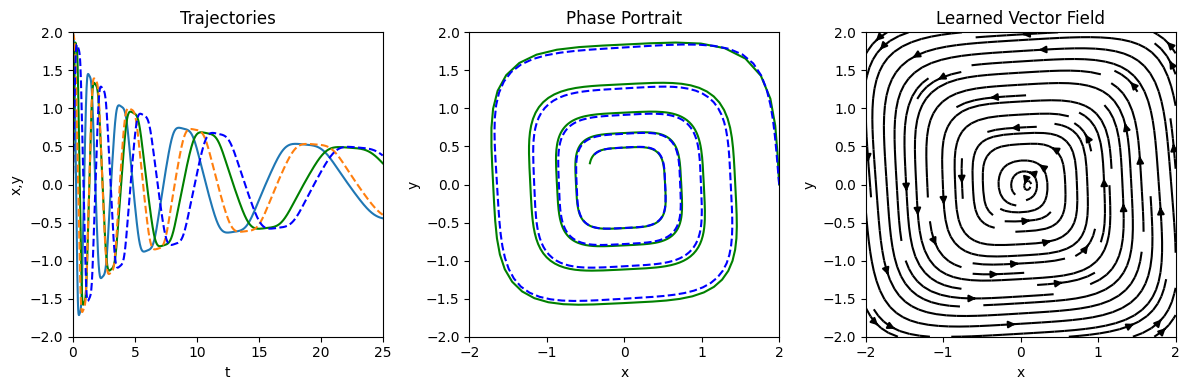

Iter 0135 | Total Loss 0.319474


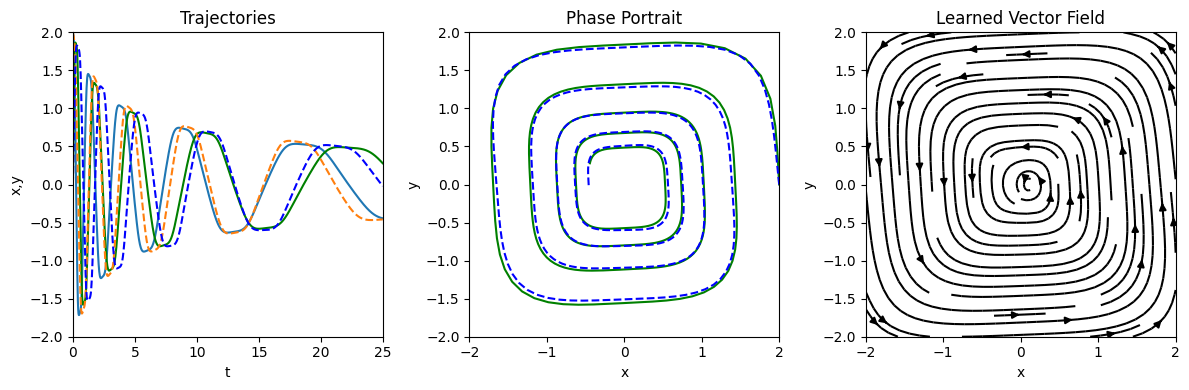

Iter 0140 | Total Loss 0.411573


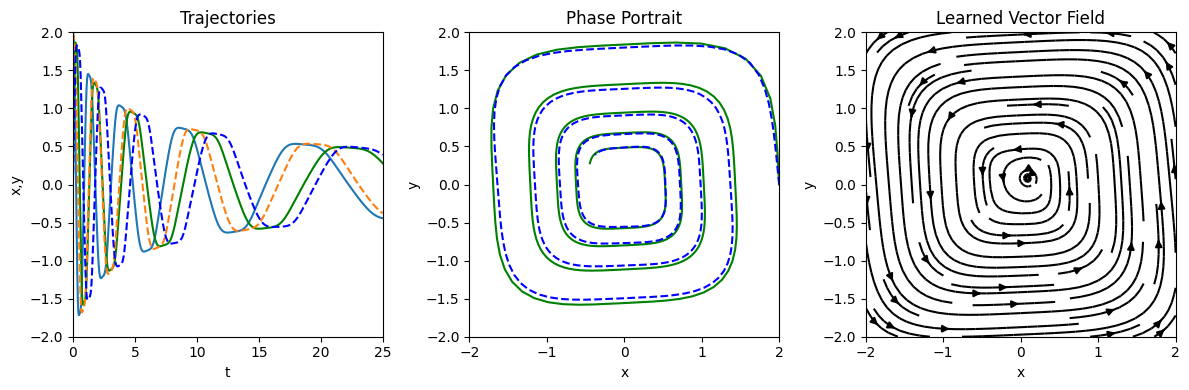

Iter 0145 | Total Loss 0.662814


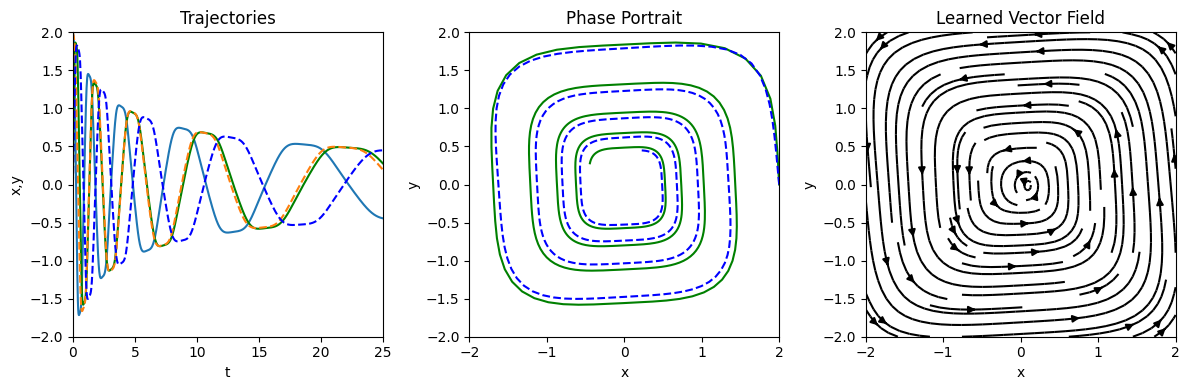

Iter 0150 | Total Loss 0.521454


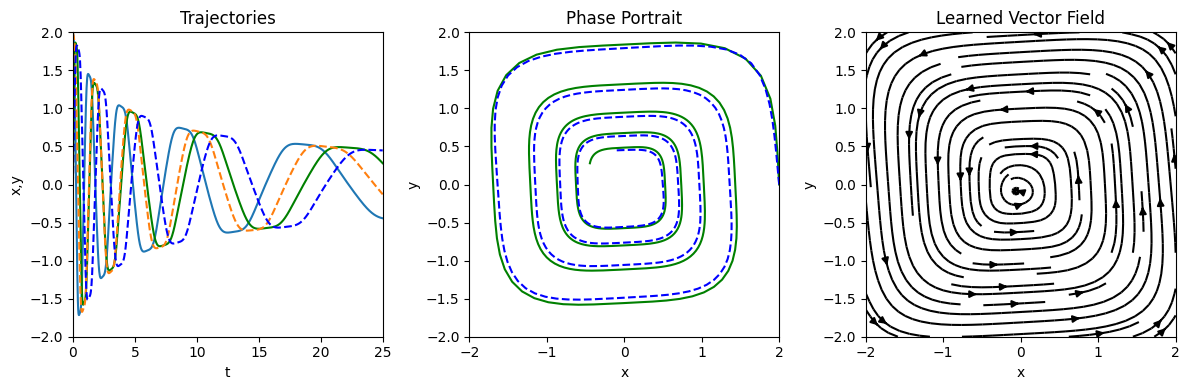

Iter 0155 | Total Loss 0.342660


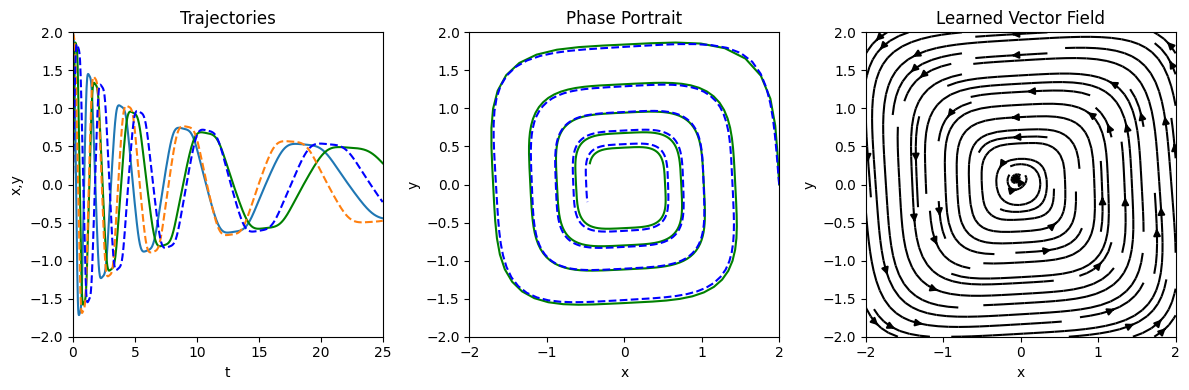

Iter 0160 | Total Loss 0.491271


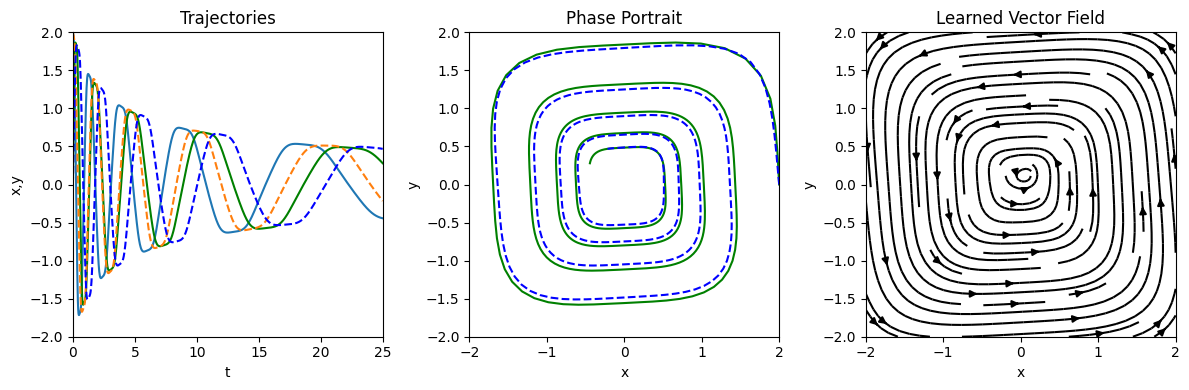

Iter 0165 | Total Loss 0.443151


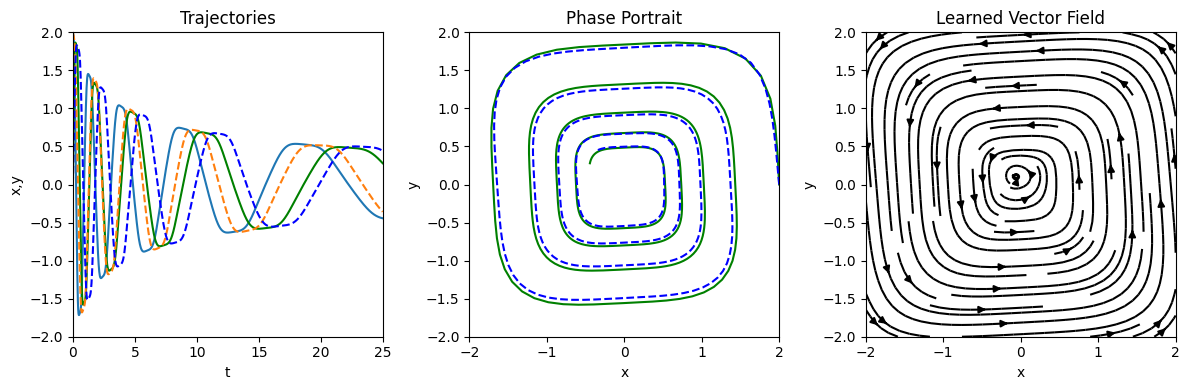

Iter 0170 | Total Loss 0.561074


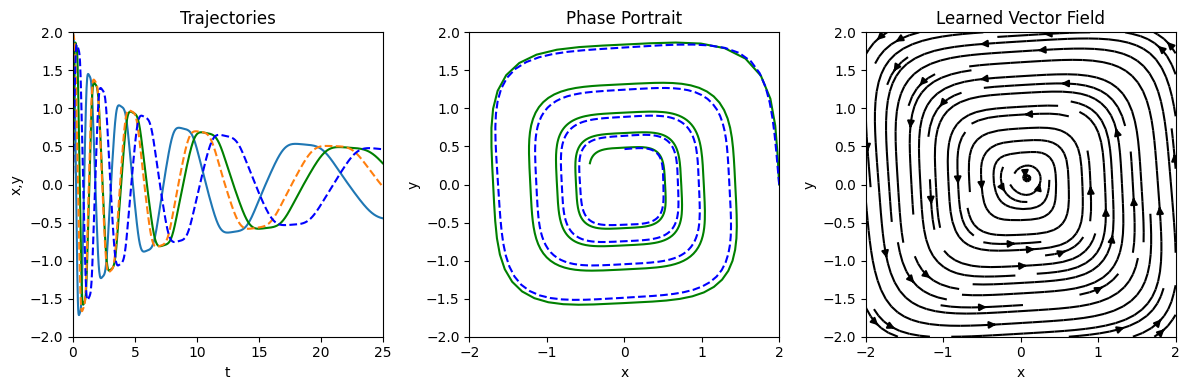

Iter 0175 | Total Loss 0.312924


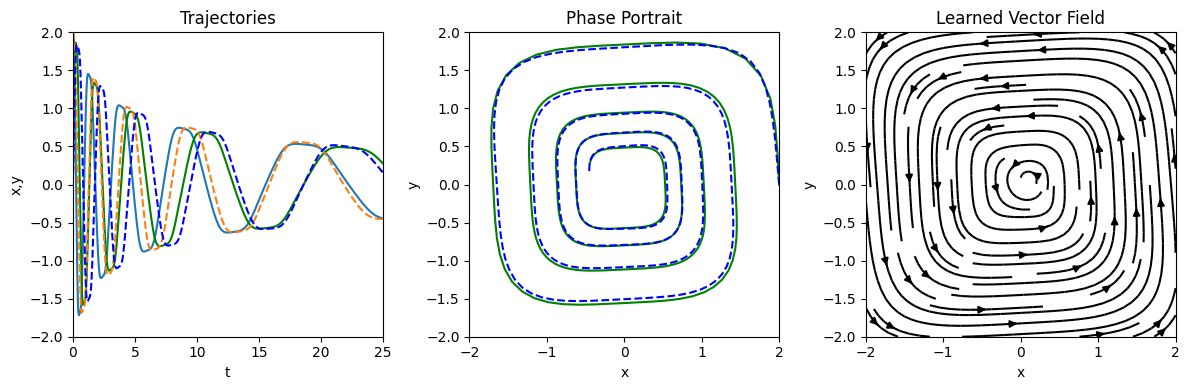

Iter 0180 | Total Loss 0.859165


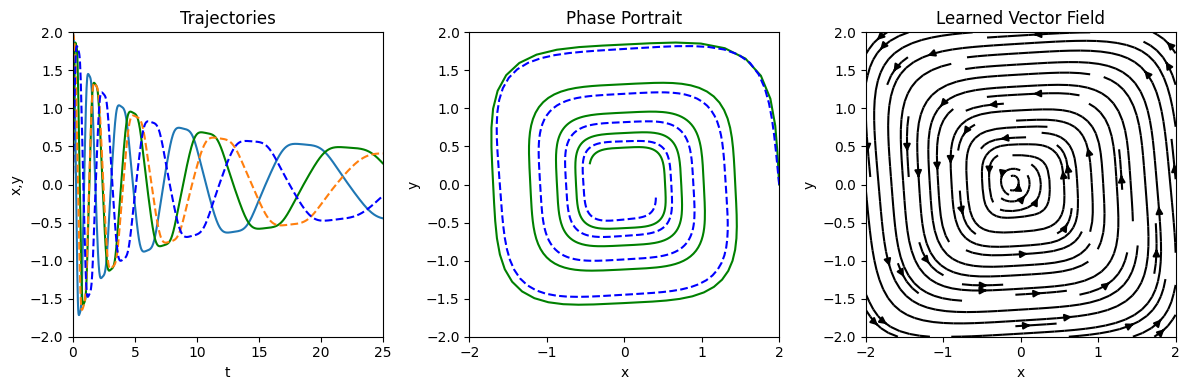

Iter 0185 | Total Loss 0.525448


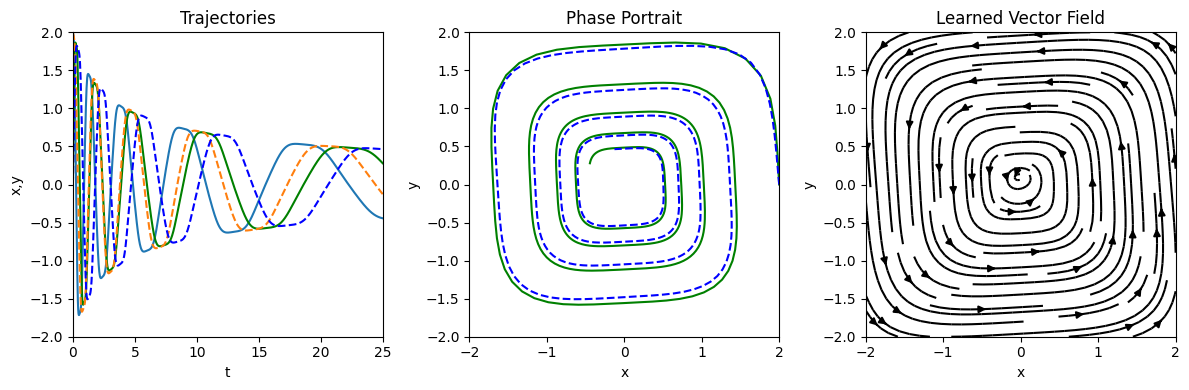

Iter 0190 | Total Loss 0.579747


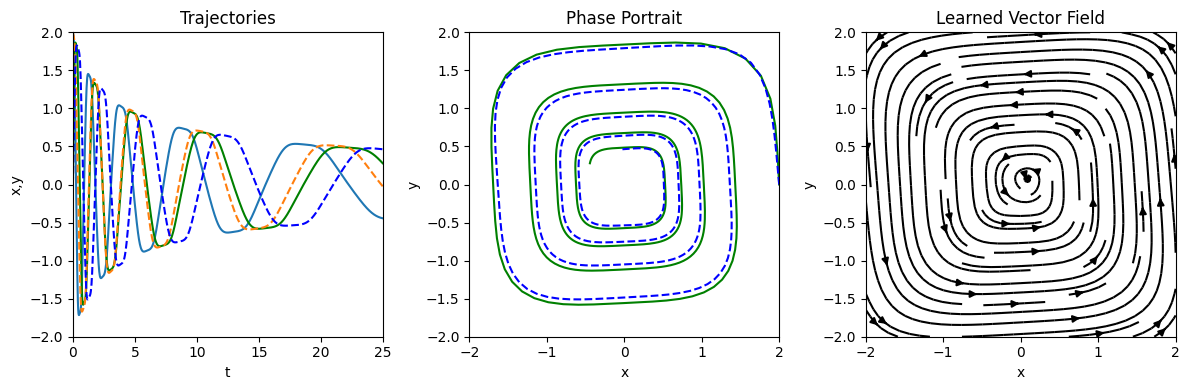

Iter 0195 | Total Loss 0.427463


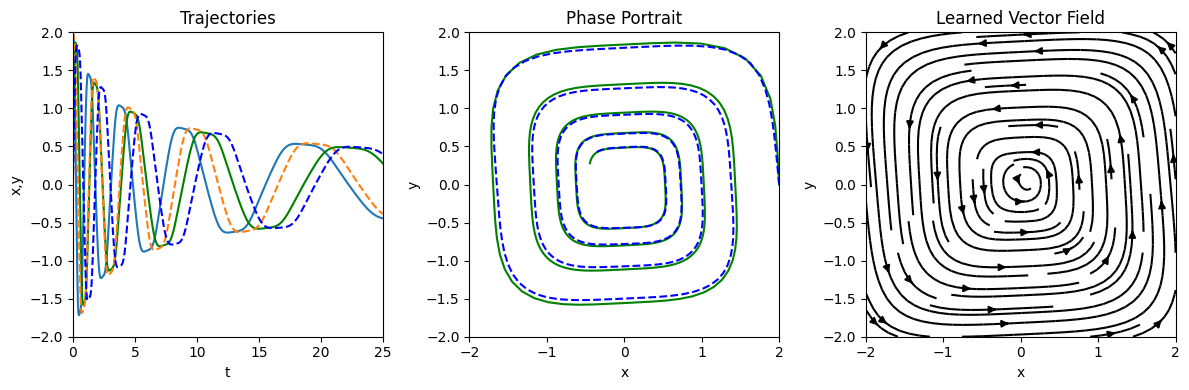

Iter 0200 | Total Loss 0.329134


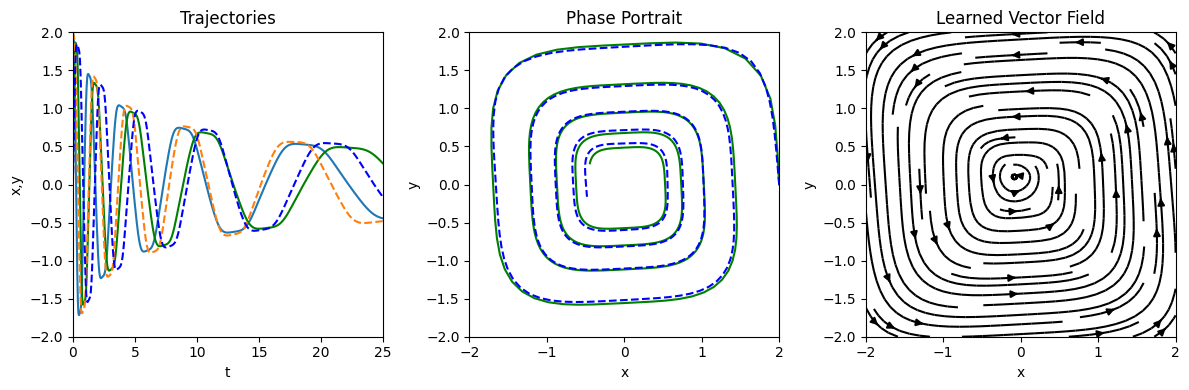

In [88]:

func = ODEFunc().to(device)

optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

ii = 0
end = time.time()

for itr in range(1, args.niters + 1):
    
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % args.test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()
    

## More visualization (after training)

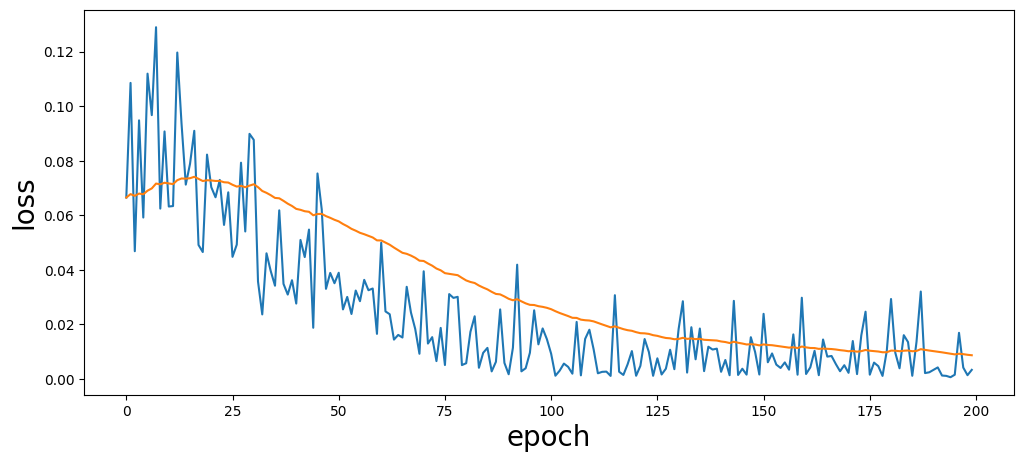

In [89]:
plt.figure(figsize=(12,5))
plt.plot(loss_meter.history['val'])
plt.plot(loss_meter.history['avg'])
plt.ylabel('loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.show()